In [2]:
import pandas as pd
import glob
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import scipy.stats as stats

%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [3]:
nba_df = pd.read_csv('data/nba_df.csv')
nba_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TOV,PF,PTS,YEAR,ORtg,DRtg,SALARY,salary_cap,scale,SALARY_2021
0,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,1.7,2.8,13.9,2018,125.0,107,22471910.0,99093000.0,1.10139,2.475033e+07
1,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,1.0,2.0,6.9,2018,116.0,105,2955840.0,99093000.0,1.10139,3.255531e+06
2,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,...,0.0,0.5,0.6,2018,85.0,107,7300000.0,99093000.0,1.10139,8.040144e+06
3,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,...,1.5,2.1,23.1,2018,118.0,105,21461010.0,99093000.0,1.10139,2.363693e+07
4,Jarrett Allen,C,19,BRK,72,31,20.0,3.3,5.5,0.589,...,1.1,2.0,8.2,2018,119.0,108,2034120.0,99093000.0,1.10139,2.240359e+06


This tool is meant to predict an NBA player's salary. Due to current salary cap and contract regulations, this analysis won't be appropriate for all players. A player's first deal, a rookie contract, is set in stone and superstar athletes are limited by maximum contract provisions. To account for this, I will be flagging these players. For simplicity, I am assuming that rookies are under the age of 23 and max contract players are those whose salary is 25% of the cap or greater. Also, I will be filtering out players who played fewer than 10 games in a given season for credibility purposes

In [4]:
nba_df['rookie_flag'] = nba_df['Age'] < 23
nba_df['rookie_flag'] = nba_df['rookie_flag'].astype(int)
nba_df[nba_df['rookie_flag'] == 0]

nba_df['max_flag'] = (nba_df['SALARY'] / nba_df['salary_cap']) > .25
nba_df['max_flag'] = nba_df['max_flag'].astype(int)
nba_df[(nba_df['max_flag'] == 0) & (nba_df['rookie_flag'] == 0)].head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PTS,YEAR,ORtg,DRtg,SALARY,salary_cap,scale,SALARY_2021,rookie_flag,max_flag
0,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,13.9,2018,125.0,107,22471910.0,99093000.0,1.10139,2.475033e+07,0,0
2,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,...,0.6,2018,85.0,107,7300000.0,99093000.0,1.10139,8.040144e+06,0,0
3,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,...,23.1,2018,118.0,105,21461010.0,99093000.0,1.10139,2.363693e+07,0,0
5,Tony Allen,SF,36,NOP,22,0,12.4,2.0,4.1,0.484,...,4.7,2018,95.0,110,1471382.0,99093000.0,1.10139,1.620565e+06,0,0
6,Al-Farouq Aminu,PF,27,POR,69,67,30.0,3.3,8.4,0.395,...,9.3,2018,105.0,104,7319035.0,99093000.0,1.10139,8.061109e+06,0,0


In [5]:
nba_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'YEAR', 'ORtg',
       'DRtg', 'SALARY', 'salary_cap', 'scale', 'SALARY_2021', 'rookie_flag',
       'max_flag'],
      dtype='object')

**Feagure Engineering**

Variables Added:

- "Stocks". This is steals + blocks, and is commonly used as an aggregate term in NBA Analytics circles to simplify defensive stats

- 3 and D interaction term. Versatility is in high demand, so I am including an interaction term of 3 pointers made multiplied by steals and blocks.

- [True Shooting Percentage](https://www.breakthroughbasketball.com/stats/tsp_calc.html) (TS%). True Shooting Percentage is commonly used in NBA as a metric to judge overall shooting. It takes into account field goals, three pointers, and free throws into one comprehensive number. The formula is Points / (2 * (FGA + 0.44 * FTA))

- Past peak indicator. Typically, players start to decline once they hit the wrong side of 35. I would expect age to be positively correlated with salary prior to age 35, to account for player improvement and reputation/basketball IQ, but be negatively correlated as players decline in skill and take on reduced roles and/or ring chase. This indicator helps address the nonlinear relationship


- Fouls per Minute. Fouls and Turnovers are both positively correlated with Salary, despite both being detrimental to team performance. The reason for this is because the best players are on the court longer, increasing the likelihood of them committing fouls and turnovers. TOV% mitigates this phenomenon for turnovers, and fouls per minute will for personal fouls.

- Turnover Rate (TOV%). Turnovers after being controlled for time spent on court. The formula is Turnovers / (2 * (FGA + 0.44 * FTA + Turnovers))

- Square root transformation of Salary. Because independent variables are small nominally (typically under 100) while Salary is in the millions, we risk explosiveness and volatility in the model.

In [6]:
##Feature engineering
nba_df['3andD'] = nba_df['3P'] * (nba_df['STL'] + nba_df['BLK'])
nba_df['STOCKS'] = nba_df['STL'] + nba_df['BLK']
nba_df['TS%'] = (nba_df['PTS'] / (2*(nba_df['FGA'] + 0.44 * nba_df['FTA'])).fillna(0))
nba_df['TS%'].replace([np.inf, -np.inf], 0,inplace=True)
nba_df['PASTPEAK'] = nba_df['Age'] > 35
nba_df['PASTPEAK'] = nba_df['PASTPEAK'].astype(int)
nba_df['PFpermin'] = nba_df['PF'] / nba_df['MP']
nba_df['TOV%'] = nba_df['TOV'] / (2*(nba_df['FGA'] + 0.44 * nba_df['FTA'] + nba_df['TOV'])).fillna(0)
nba_df['TOV%'].replace([np.inf, -np.inf], 0,inplace=True)
nba_df['SALARY_2021_log'] = np.log(nba_df['SALARY_2021'])
nba_df['SALARY_2021_sqrt'] = np.sqrt(nba_df['SALARY_2021'])
nba_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,rookie_flag,max_flag,3andD,STOCKS,TS%,PASTPEAK,PFpermin,TOV%,SALARY_2021_log,SALARY_2021_sqrt
0,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,0,0,0.00,2.2,0.627710,0,0.085627,0.066552,17.024349,4974.970156
1,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,1,0,0.00,1.1,0.570814,0,0.101010,0.070982,14.995866,1804.309133
2,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,...,0,0,0.00,0.1,0.360577,0,0.217391,0.000000,15.899958,2835.514787
3,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,...,0,0,0.72,1.8,0.568070,0,0.062687,0.034353,16.978321,4861.782934
4,Jarrett Allen,C,19,BRK,72,31,20.0,3.3,5.5,0.589,...,1,0,0.16,1.6,0.642633,0,0.100000,0.073529,14.622147,1496.782757


Apply filters and reduce data points for dataframe used for regression

In [7]:
nba_df_small = nba_df[(nba_df['max_flag'] == 0) & (nba_df['rookie_flag'] == 0)
                           & (nba_df['G'] > 10)] \
                    [['Player','YEAR','Age','PASTPEAK','FGA','3P','FTA','ORB','DRB',
                      'AST', 'STOCKS','PFpermin', 'PTS','ORtg', 'DRtg',
                      '3andD','TS%','TOV%','SALARY_2021_sqrt']]

nba_df_small.sort_values('TOV%',ascending=False)

,Player,YEAR,Age,PASTPEAK,FGA,3P,FTA,ORB,DRB,AST,STOCKS,PFpermin,PTS,ORtg,DRtg,3andD,TS%,TOV%,SALARY_2021_sqrt
39,Andrew Bogut,2018,33,0,1.0,0.0,0.1,1.1,2.2,0.6,0.7,0.188889,1.5,106.0,104,0.00,0.718391,0.216920,1273.014076
1254,Michael Kidd-Gilchrist,2020,26,0,1.0,0.0,0.4,0.4,2.1,0.3,0.4,0.161290,0.9,71.0,110,0.00,0.382653,0.186567,771.441508
562,Matthew Dellavedova,2019,28,0,1.6,0.3,0.3,0.0,0.8,2.4,0.2,0.098765,1.7,99.0,110,0.06,0.490762,0.170973,3208.308706
359,Julyan Stone,2018,29,0,0.6,0.3,0.1,0.0,1.2,1.1,0.3,0.118421,0.8,123.0,110,0.09,0.621118,0.158898,1350.556371
1942,Chris Silva,2021,24,0,1.1,0.1,1.0,0.5,1.3,0.4,0.5,0.262295,2.1,110.0,109,0.05,0.681818,0.156250,1232.063716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Justin Jackson,2020,24,0,5.2,0.7,0.8,0.4,2.0,0.8,0.4,0.068323,5.5,108.0,115,0.28,0.495317,0.017385,1811.331002
533,Gary Clark,2019,24,0,3.0,0.8,0.1,0.5,1.8,0.4,0.9,0.071429,2.9,108.0,110,0.72,0.476347,0.015903,799.672056
1078,Gary Clark,2020,25,0,3.3,1.0,0.4,0.6,1.6,0.7,0.5,0.101695,3.9,126.0,113,0.50,0.560990,0.013982,745.257674
688,Justin Jackson,2019,23,0,6.6,1.1,1.0,0.7,1.6,1.0,0.3,0.060109,8.2,121.0,115,0.33,0.582386,0.013812,1734.443771


In [8]:
nba_df_small.corr()

,YEAR,Age,PASTPEAK,FGA,3P,FTA,ORB,DRB,AST,STOCKS,PFpermin,PTS,ORtg,DRtg,3andD,TS%,TOV%,SALARY_2021_sqrt
YEAR,1.000000,-0.016634,-0.096591,-0.039772,0.057018,-0.058208,-0.003315,-0.000125,-0.009254,0.005582,-0.017648,-0.028839,0.124126,0.272814,0.033332,0.085153,-0.024443,-0.106791
Age,-0.016634,1.000000,0.433438,-0.096619,0.022123,-0.107582,-0.049132,-0.012856,0.009069,-0.028513,-0.002350,-0.099589,0.042446,-0.017997,-0.006019,0.023775,0.093132,0.156647
PASTPEAK,-0.096591,0.433438,1.000000,-0.063762,-0.027529,-0.068479,-0.059248,-0.033047,-0.044759,-0.081295,-0.018130,-0.069680,-0.033483,-0.013513,-0.054067,-0.011883,0.054822,-0.060984
FGA,-0.039772,-0.096619,-0.063762,1.000000,0.674594,0.781177,0.185934,0.514566,0.629166,0.495408,-0.415218,0.979534,0.056873,0.075484,0.696849,0.113791,-0.230060,0.520416
3P,0.057018,0.022123,-0.027529,0.674594,1.000000,0.280242,-0.315616,0.107181,0.382361,0.143912,-0.449578,0.628924,-0.001458,0.278689,0.814696,0.080530,-0.342614,0.311692
FTA,-0.058208,-0.107582,-0.068479,0.781177,0.280242,1.000000,0.410380,0.614760,0.524995,0.537418,-0.183301,0.850017,0.195810,-0.104677,0.423646,0.240136,-0.028523,0.468511
ORB,-0.003315,-0.049132,-0.059248,0.185934,-0.315616,0.410380,1.000000,0.724622,-0.033462,0.508872,0.209756,0.273158,0.410799,-0.377601,-0.093777,0.354390,0.091125,0.245230
DRB,-0.000125,-0.012856,-0.033047,0.514566,0.107181,0.614760,0.724622,1.000000,0.265223,0.657045,-0.008187,0.578980,0.282548,-0.375797,0.311404,0.316700,0.051497,0.449306
AST,-0.009254,0.009069,-0.044759,0.629166,0.382361,0.524995,-0.033462,0.265223,1.000000,0.357971,-0.370278,0.598772,0.033299,0.085408,0.440211,-0.031830,0.217737,0.370495
STOCKS,0.005582,-0.028513,-0.081295,0.495408,0.143912,0.537418,0.508872,0.657045,0.357971,1.000000,-0.008067,0.534266,0.218802,-0.434580,0.555724,0.233316,0.054783,0.434144


In [9]:
corr = nba_df_small.corr().loc['SALARY_2021_sqrt'].round(2)
corr_df = pd.DataFrame(data=corr)
corr_df.rename(columns={'SALARY_2021_sqrt':'salary_corr'},inplace=True)
corr_df

,salary_corr
YEAR,-0.11
Age,0.16
PASTPEAK,-0.06
FGA,0.52
3P,0.31
FTA,0.47
ORB,0.25
DRB,0.45
AST,0.37
STOCKS,0.43


In [10]:
nba_df_small.columns

Index(['Player', 'YEAR', 'Age', 'PASTPEAK', 'FGA', '3P', 'FTA', 'ORB', 'DRB',
       'AST', 'STOCKS', 'PFpermin', 'PTS', 'ORtg', 'DRtg', '3andD', 'TS%',
       'TOV%', 'SALARY_2021_sqrt'],
      dtype='object')

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [12]:
vif(nba_df_small.drop(columns=['Player','SALARY_2021_sqrt','ORtg','DRtg','TOV%','FGA','TS%']))

YEAR        104.411945
Age          79.929205
PASTPEAK      1.286647
3P           23.900412
FTA          16.518696
ORB           9.436970
DRB          14.549198
AST           5.268892
STOCKS       18.649399
PFpermin     13.859119
PTS          51.654840
3andD        14.800643
dtype: float64

Despite the multicollinearity still present, these variables all have strong correlations to salary. Ridge or Lasso regression can be applied to introduce generalization

I originally added in offensive and defensive rating metrics to add additional color since they measure impact from another angle, from a +/- perspective. However, it appears that they both have high multicollinearity issues with the other metrics. I will be dropping them from the models.

TS% has multicollinearity issues and has a surprisingly low correlation with salary. This will be removed.

**K-fold cross validation**

In [13]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import KFold
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = nba_df_small.drop(columns=['Player','SALARY_2021_sqrt','ORtg','DRtg','TOV%','FGA','TS%'])
y = nba_df_small['SALARY_2021_sqrt']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

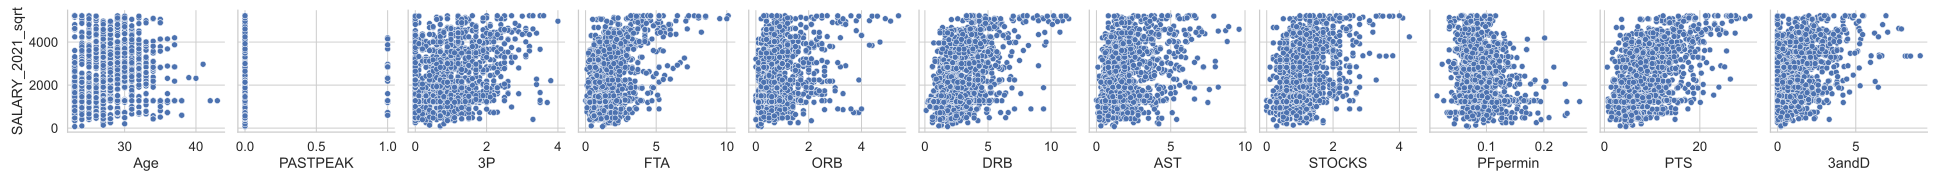

In [14]:
pair_df = X.copy()
pair_df['SALARY_2021_sqrt'] = y
sns.pairplot(pair_df,x_vars=pair_df.drop(columns=['YEAR','SALARY_2021_sqrt']),
             y_vars=['SALARY_2021_sqrt']);

In [15]:
##Initial analysis before K-fold
X_sm = X_train.copy()
X_sm = sm.add_constant(X_sm)
statsmodel = sm.OLS(y_train,X_sm)

nba_model = statsmodel.fit()
nba_model.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SALARY_2021_sqrt   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          6.63e-112
Time:                        15:03:11   Log-Likelihood:                -9205.7
No. Observations:                1104   AIC:                         1.844e+04
Df Residuals:                    1091   BIC:                         1.850e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.782e+05   5.73e+04      4.854      0.000    1.66e+05    3.91e+05
YEAR        -138.1596     28.381     -4.868      0.000    -193.848     -82.472
Age           87.0787      9.972      8.733      0.000      67.513     106.645
PASTPEAK   -1132.7154    221.550     -5.113      0.000   -1567.428    -698.003
3P          -108.4062    117.822     -0.920      0.358    -339.590     122.778
FTA           38.9481     55.293      0.704      0.481     -69.544     147.440
ORB          147.8539     81.306      1.818      0.069     -11.679     307.387
DRB          104.4093     34.828      2.998      0.003      36.072     172.747
AST           54.8966     28.124      1.952      0.051      -0.286     110.079
STOCKS        80.7081    106.399      0.759      0.448    -128.062     289.478
PFpermin   -5313.6192   1190.199     -4.464      0.000   -7648.957   -2978.281
PTS           54.1170     21.189      2.554      0.011      12.541      95.693
3andD        181.4179     66.000      2.749      0.006      51.916     310.920
==============================================================================
Omnibus:                        8.861   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.397
Skew:                           0.124   Prob(JB):                       0.0248
Kurtosis:                       2.685   Cond. No.                     3.78e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

**OLS**

In [17]:
lin_reg = LinearRegression().fit(X_train,y_train)
scores = cross_val_score(lin_reg, X_train, y_train, cv=kfold,scoring='r2')

print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))
print("Linear Reg Test R2: ", lin_reg.score(X_test,y_test))
print(f'OLS MAE: {mean_absolute_error(y_train,lin_reg.predict(X_train))}')
list(zip(X_train.columns, lin_reg.coef_))

[0.37491393 0.32170404 0.38722733 0.3514679  0.46689088]
Linear Reg Mean Score:  0.3804408166137865
Linear Reg Test R2:  0.3980080752129863
OLS MAE: 809.7720765319259


[('YEAR', -138.1595988512619),
 ('Age', 87.07870568485228),
 ('PASTPEAK', -1132.715431910144),
 ('3P', -108.4061809109226),
 ('FTA', 38.9480942638371),
 ('ORB', 147.85394421989284),
 ('DRB', 104.4093049003357),
 ('AST', 54.896569990072486),
 ('STOCKS', 80.70811911676503),
 ('PFpermin', -5313.619194432498),
 ('PTS', 54.11698586350642),
 ('3andD', 181.41786082716771)]

**Lasso Regression**

In [18]:
std = StandardScaler()
std.fit(X_train.values)

X_std = std.transform(X.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [19]:
lasso_alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = lasso_alphas, cv=5)
lasso_model.fit(X_tr, y_train)
lasso_model.score(X_tr, y_train)
r_squared_test = lasso_model.score(X_te, y_test)
lasso_model.alpha_

8.21434358491943

In [20]:
lasso_reg = Lasso(alpha = lasso_model.alpha_).fit(X_tr,y_train)
lasso_scores = cross_val_score(lasso_reg, X_tr, y_train, cv=kfold)

print(lasso_scores)
print("Lasso Reg Mean Score: ", np.mean(lasso_scores))
print("Lasso Reg Test R2: ", lasso_reg.score(X_te,y_test))
print(f'Lasso MAE: {mean_absolute_error(y_train,lasso_reg.predict(X_tr))}')
list(zip(X_train.columns, lasso_reg.coef_))

[0.37357736 0.32643213 0.38608546 0.34884865 0.46573417]
Lasso Reg Mean Score:  0.38013555431574575
Lasso Reg Test R2:  0.3998360658466191
Lasso MAE: 813.6763842218595


[('YEAR', -144.1517292833951),
 ('Age', 287.868619730697),
 ('PASTPEAK', -160.259543369518),
 ('3P', -0.0),
 ('FTA', 74.17784662448436),
 ('ORB', 109.75835273381242),
 ('DRB', 172.44034653991224),
 ('AST', 81.71463666475985),
 ('STOCKS', 91.20945650939717),
 ('PFpermin', -149.23645646619576),
 ('PTS', 241.88850355255173),
 ('3andD', 168.3539612052279)]

**Ridge Regression**

In [21]:
alphas = 10**np.linspace(-2,3,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr, y_train)
ridge_model.score(X_tr, y_train)
r_squared_test = ridge_model.score(X_te, y_test)
ridge_model.alpha_

88.04883581643465

In [22]:
ridge_reg = Ridge(alpha = ridge_model.alpha_).fit(X_tr,y_train)
ridge_scores = cross_val_score(lasso_reg, X_tr, y_train, cv=kfold,scoring='r2')

print(ridge_scores)
print("Ridge Reg Mean Score: ", np.mean(ridge_scores))
print("Ridge Reg Test R2: ", ridge_reg.score(X_te,y_test))
print(f'Ridge MAE: {mean_absolute_error(y_train,ridge_reg.predict(X_tr))}')
list(zip(X_train.columns, ridge_reg.coef_))

[0.37357736 0.32643213 0.38608546 0.34884865 0.46573417]
Ridge Reg Mean Score:  0.38013555431574575
Ridge Reg Test R2:  0.3966186104718362
Ridge MAE: 816.894275762969


[('YEAR', -141.0844119997778),
 ('Age', 267.03355666716277),
 ('PASTPEAK', -146.54462094870655),
 ('3P', 24.105649251294718),
 ('FTA', 105.35496460468413),
 ('ORB', 117.69477336443501),
 ('DRB', 163.54097256989186),
 ('AST', 91.82289737561733),
 ('STOCKS', 103.3561405675876),
 ('PFpermin', -148.50600878834072),
 ('PTS', 188.22365430118973),
 ('3andD', 160.02391574622106)]

In [23]:
Coefficients = pd.DataFrame(list(zip(X_train.columns,lin_reg.coef_,lasso_reg.coef_,ridge_reg.coef_)),
                           columns=['Field','OLS_Coef','Lasso_coef','Ridge_coef'])
#Coefficients.round(2).to_csv('coefficienttable.csv')
Coefficients.round(2)

,Field,OLS_Coef,Lasso_coef,Ridge_coef
0,YEAR,-138.16,-144.15,-141.08
1,Age,87.08,287.87,267.03
2,PASTPEAK,-1132.72,-160.26,-146.54
3,3P,-108.41,-0.00,24.11
4,FTA,38.95,74.18,105.35
5,ORB,147.85,109.76,117.69
6,DRB,104.41,172.44,163.54
7,AST,54.90,81.71,91.82
8,STOCKS,80.71,91.21,103.36
9,PFpermin,-5313.62,-149.24,-148.51


In [24]:
metrics = list(zip(['OLS','Lasso','Ridge'],
         [[np.mean(scores),lin_reg.score(X_test,y_test),mean_absolute_error(y_train,lin_reg.predict(X_train))],
         [np.mean(lasso_scores),lasso_reg.score(X_te,y_test),mean_absolute_error(y_train,lasso_reg.predict(X_tr))],
         [np.mean(ridge_scores),ridge_reg.score(X_te,y_test),mean_absolute_error(y_train,ridge_reg.predict(X_tr))]]))
metrics = list(zip(['OLS','Lasso','Ridge'],[np.mean(scores),np.mean(lasso_scores),np.mean(ridge_scores)],
                  [lin_reg.score(X_test,y_test),lasso_reg.score(X_te,y_test),ridge_reg.score(X_te,y_test)],
                  [mean_absolute_error(y_train,lin_reg.predict(X_train)),mean_absolute_error(y_train,lasso_reg.predict(X_tr)),
                  mean_absolute_error(y_train,ridge_reg.predict(X_tr))]))
metrics_df = pd.DataFrame(metrics,columns=['Model','r^2 Train','r^2 Test','MAE'])
metrics_df['MAE^2'] = metrics_df['MAE'] ** 2
#metrics_df.round(4).to_csv('metrics.csv')
metrics_df
##Added MAE^2 to express the error in nominal salary terms, rather than square root of salary

,Model,r^2 Train,r^2 Test,MAE,MAE^2
0,OLS,0.380441,0.398008,809.772077,655730.815931
1,Lasso,0.380136,0.399836,813.676384,662069.258240
2,Ridge,0.380136,0.396619,816.894276,667316.257774


In all three cases, the r^2 train, test, and MAE are not that far off from each other. However, the Ridge Regression model had the most intuitive results. In OLS, 3 Pointers has a negative coefficient and fouls per minute and past peak have explosive coefficients. In Lasso, the explosiveness is mitigated but 3 Pointer coefficient is reduced to 0. In today's 3-point oriented league, 3 pointers should have a positive standalone impact, in addition to the impact already present in 3 and D and Points. For this reason, Ridge makes the most sense.

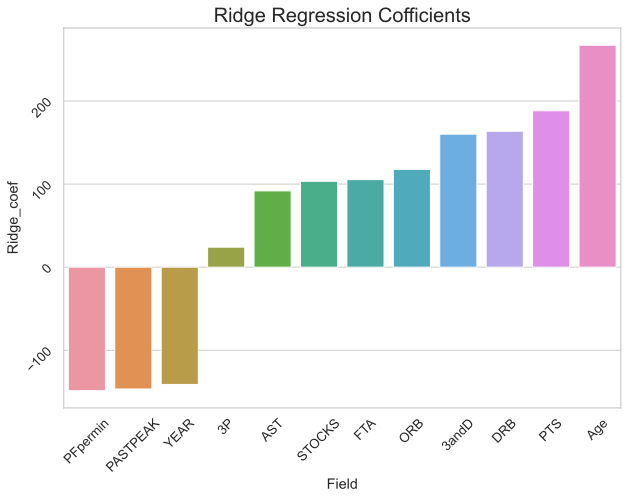

In [25]:
ridge_coef = Coefficients[['Field','Ridge_coef']].sort_values('Ridge_coef')

fig,ax = plt.subplots(figsize = (10,7))
sns.barplot(data=ridge_coef,x='Field',y='Ridge_coef')
plt.title('Ridge Regression Cofficients',fontsize=20)
ax.tick_params(rotation=45)
plt.savefig('coefficients.png');

Ridge Grid Search


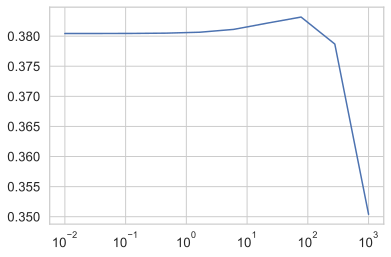

In [26]:
#Map of alphas for ridge regression vs r^2
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_tr, y_train, cv=kfold,
                                       alpha=np.logspace(-2, 3, 10));

In [27]:
def diagnostic_plots(y_pred, y_true):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    
    resid = y_true - y_pred

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    #g1.plot(y_true, y_true, '--', color='gray')
    m,b = np.polyfit(y_pred,y_true,1)
    g1.plot(y_pred,m*y_pred + b)

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [28]:
##For Predictive plotting
X_PR = X.copy()
X_PR['pred'] = ridge_reg.predict(X_std) ** 2
#X_PR['pred'] = lm.predict(X_train)
X_PR['act'] = y ** 2
#PRtest = nba_df_small.copy()
#nba_df_small.iloc[89]
X_PR['diff'] = X_PR['act'] - X_PR['pred']
X_PR.sort_values('pred')
#nba_df_small.loc[1004]

,YEAR,Age,PASTPEAK,3P,FTA,ORB,DRB,AST,STOCKS,PFpermin,PTS,3andD,pred,act,diff
1772,2021,23,0,0.2,0.3,0.0,0.6,0.2,0.2,0.195122,1.2,0.04,4.258884e+04,1.544330e+05,1.118442e+05
1942,2021,24,0,0.1,1.0,0.5,1.3,0.4,0.5,0.262295,2.1,0.05,6.112400e+04,1.517981e+06,1.456857e+06
1943,2021,24,0,0.1,1.4,0.6,1.6,0.5,0.6,0.240000,2.7,0.06,2.250835e+05,1.517981e+06,1.292898e+06
1761,2021,25,0,0.0,0.8,0.5,0.8,0.3,0.5,0.208955,1.6,0.00,2.335870e+05,2.379650e+05,4.377964e+03
1844,2021,23,0,0.1,0.2,0.3,0.7,0.3,0.1,0.137255,1.2,0.01,2.656621e+05,1.517981e+06,1.252319e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2020,25,0,1.4,10.0,2.2,11.4,5.6,2.0,0.101974,29.5,2.80,2.554824e+07,2.584270e+07,2.944541e+05
585,2019,24,0,1.2,10.1,2.5,11.1,3.7,2.6,0.097923,27.5,3.12,2.596561e+07,2.728500e+07,1.319389e+06
99,2018,24,0,0.7,8.0,2.5,8.6,2.3,4.1,0.057692,28.1,2.87,2.660033e+07,2.618610e+07,-4.142351e+05
554,2019,25,0,0.9,7.7,3.1,8.9,3.9,4.0,0.072727,25.9,3.60,2.728337e+07,2.724966e+07,-3.371275e+04


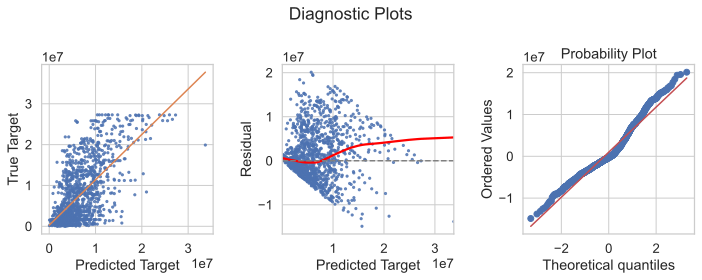

In [29]:
diagnostic_plots(X_PR['pred'], X_PR['act'])
#plt.savefig('diagnostics.png')
##Q-Q plots and residual plots support mean of 0, but there is some heteroskedasticity that a Y transformation
#did not fully mitigate

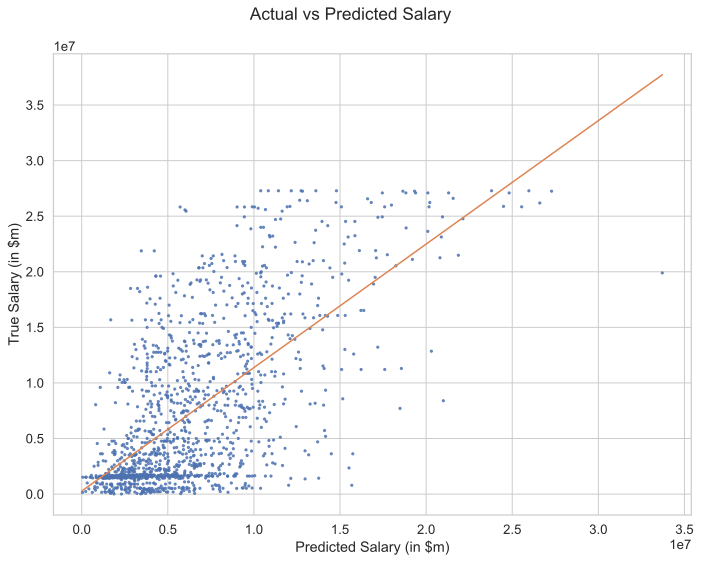

In [30]:
def predictive_plot(y_pred, y_true):
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    
    resid = y_true - y_pred

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes, scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Salary (in $m)')
    g1.set_ylabel('True Salary (in $m)')
    #g1.plot(y_true, y_true, '--', color='gray')
    m,b = np.polyfit(y_pred,y_true,1)
    g1.plot(y_pred,m*y_pred + b)

    fig.suptitle('Actual vs Predicted Salary');
    fig.tight_layout();
    
predictive_plot(X_PR['pred'], X_PR['act'])
#plt.savefig('predictive_plot.png')

This section provides examples of players where the actual and predicted salary differ significantly. These disparities can help identify undervalued and overvalued players. However, there are players known for intangibles that this model can't quantify, leading to mismatches.

In [30]:
##For individual player analysis
#Pascal Siakam - MIP winner still on previous contract
PRtest = nba_df_small.copy()
nba_df_small.iloc[89]
X_PR['diff'] = X_PR['act'] - X_PR['pred']
X_PR2 = X_PR[['act','pred','diff']]
PRtest = PRtest.merge(X_PR2,how='inner',left_index=True,right_index=True)
PRtest.sort_values('diff')

PRtest.loc[1402]

Player                Pascal Siakam
YEAR                           2020
Age                              25
PASTPEAK                          0
FGA                            18.4
3P                              2.2
FTA                             5.1
ORB                             1.1
DRB                             6.3
AST                             3.5
STOCKS                          1.9
PFpermin                   0.079545
PTS                            22.9
ORtg                          107.0
DRtg                            105
3andD                          4.18
TS%                        0.554641
TOV%                        0.05401
SALARY_2021_sqrt         1533.57067
act                       2351839.0
pred                15520474.725244
diff               -13168635.725244
Name: 1402, dtype: object

In [31]:
#Mediocre player on bloated contract
PRtest.loc[952]

Player              Andrew Wiggins
YEAR                          2019
Age                             23
PASTPEAK                         0
FGA                           16.6
3P                             1.6
FTA                            4.1
ORB                            1.1
DRB                            3.7
AST                            2.5
STOCKS                         1.7
PFpermin                  0.060345
PTS                           18.1
ORtg                         100.0
DRtg                           115
3andD                         2.72
TS%                       0.491741
TOV%                      0.046789
SALARY_2021_sqrt       5223.504571
act                     27285000.0
pred                10394677.83209
diff                16890322.16791
Name: 952, dtype: object

In [32]:
#Player known for intangibles
PRtest.sort_values('diff',ascending=False).head(20)
PRtest.loc[628]

Player               Draymond Green
YEAR                           2019
Age                              28
PASTPEAK                          0
FGA                             6.4
3P                              0.7
FTA                             1.4
ORB                             0.9
DRB                             6.4
AST                             6.9
STOCKS                          2.5
PFpermin                   0.095847
PTS                             7.4
ORtg                          108.0
DRtg                            106
3andD                          1.75
TS%                        0.527366
TOV%                       0.135191
SALARY_2021_sqrt         4326.25385
act                 18716472.372361
pred                11075302.303904
diff                 7641170.068457
Name: 628, dtype: object